In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from math import cos, degrees, pi, log, radians
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.decomposition import PCA
%matplotlib notebook

from matplotlib import colors as clr
import matplotlib

def new_nei_set(alpha, cols_bin, perc):
    return np.flatnonzero(cols_bin[alpha]>perc)

In [1]:
# Selected colours for the pictures
cl=[(1.0,0.0,0.0,1),
(1.0,1.0,0.0,1),
(0.0,1.0,0.0,1),
(0.0,1.0,1.0,1),
(153/255,51/255,1.0,1),
(1,51/255,1,1), (0.0,0.0, 1.0, 1), (192/255, 192/255,192/255,1)]   

## TOC:
* [Calculation of optimal angles](#first-bullet)
* [Preliminary segmentation](#second-bullet)
* [Two clusters. Preliminary segmentation](#third-bullet)
* [Further segmentation of two clusters](#fourth-bullet)
* [Three clusters. Preliminary segmentation](#fifth-bullet)
* [Further segmentation of ther clusters](#sixth-bullet)

In [ ]:
# It is supposed that the data is preprocessed according to the characteristics of the instrument and data acquisition parameters, then binned and put into the following variables 
# vv -- intensities
# xx and yy -- coordinates in the the image

# Calculation of optimal angles <a class="anchor" id="first-bullet"></a>

In [ ]:
number0=len(vv)
cols_bin=1-pairwise_distances(vv, vv, metric="cosine")
min_angle=np.arccos(np.sort(cols_bin, axis=None)[-number0-1])
print("Minimal angle is ", min_angle, " radian")

In [ ]:
# alpha -- an array of densities, extr_phi -- an array of optimal angles
starttime=time.time()
delta_phi=min_angle/10
print(int(ceil(1/delta_phi)))

alpha1=[]
extr_phi1=[]
logx=np.array([degrees(i*delta_phi) for i in range(3, int(ceil(1/delta_phi)))])
for i in range(number0):
    if(i%10000==0):
        print(i)
    logy=np.array([(log(len(new_nei_set(i, cols_bin, cos(k*delta_phi)))))/log(k) for k in range (3, int(ceil(1/delta_phi)))], dtype=float)
    alpha1.append(np.amax(logy))
    extr_phi1.append(degrees((np.argmax(logy)+2)*delta_phi))
alpha1=np.array(alpha1)
extr_phi1=np.array(extr_phi1)
endtime=time.time()
print(endtime-starttime)

In [ ]:
# Picture
fig5, ax= plt.subplots(figsize=(8,8))
ax.scatter(alpha1, extr_phi1, s=1)
ax.set_xlabel("Density")
ax.set_ylabel("Max angle")
plt.show()

In [ ]:
# Filtering the outliers
z=np.flatnonzero(extr_phi1>45)
print("The number of outliers is equal to ", len(z))
ileft= np.array(list({j for j in range(number0)}.difference(set(z))))
x=xx[ileft]
y=yy[ileft]
v=np.array([vv[ileft[i]] for i in range(len(ileft))])
alpha=alpha1[ileft]
extr_phi=extr_phi1[ileft]

In [8]:
# For future pictures
extent = np.min(x), np.max(x), np.min(y), np.max(y)
xgrid=np.arange(extent[0]-0.5, extent[1]+0.5, 1)
ygrid=np.arange(extent[2]-0.5, extent[3]+0.5, 1)

Z0=[[(0.0,0.0,0.0,1.0) for j in range(len(xgrid))] for i in range(len(ygrid))]

In [9]:
# Clearing the variables
del(xx)
del(yy)
del(vv)
del(cols_bin)

# Preliminary segmentation<a class="anchor" id="second-bullet"></a>

In [ ]:
# Type 0 in reg_num for the median angle for zero approximation, or 2 or 3 for Phi/4 and Phi/4 respectively.
reg_num=2
number=len(v)
cols_bin=1-pairwise_distances(v, v, metric="cosine")
mincos=np.amin(cols_bin, axis=None)

if(reg_num==0):
    coneangle=cos(radians(np.median(extr_phi)))
elif((reg_num==2) or (reg_num==3)):
    coneangle=cos(np.arccos(mincos)/2/reg_num)
else:
    print("There is an error")

list_of_neisets=[new_nei_set(i, cols_bin, coneangle) for i in range(number)]
lenlist=np.array([len(list_of_neisets[i]) for i in range(number)])

In [ ]:
# Matrix of neighbours: if 1 then not neigbours, if 0 then are neighbours
arrofnei=np.ones((number, number), dtype=int)
for i in range(number):
    arrofnei[i][list_of_neisets[i]]=arrofnei[i][list_of_neisets[i]]-1
    
# Matrix of not-neighbours of all the neighbours. If 1 then can be an axis of the other cone
arrof_not_nei=[np.prod(arrofnei[list_of_neisets[i]], axis=0) for i in range(number)]

# Two clusters. Preliminary segmentation <a class="anchor" id="third-bullet"></a>

In [ ]:
#Search of 2 disjoint sets
starttime=time.time()
maxv=0
for i in range(number):
    try_list=np.flatnonzero(arrof_not_nei[i]>0)
    if (len(try_list)):
        try_list=np.array(try_list)
        k=np.argmax(lenlist[try_list])
        if(lenlist[i]+lenlist[try_list[k]]>maxv):
            num1=i
            num2=try_list[k]
            maxv=lenlist[i]+lenlist[try_list[k]]
endtime=time.time()
print(endtime-starttime)

print(num1, num2)

<IPython.core.display.Javascript object>


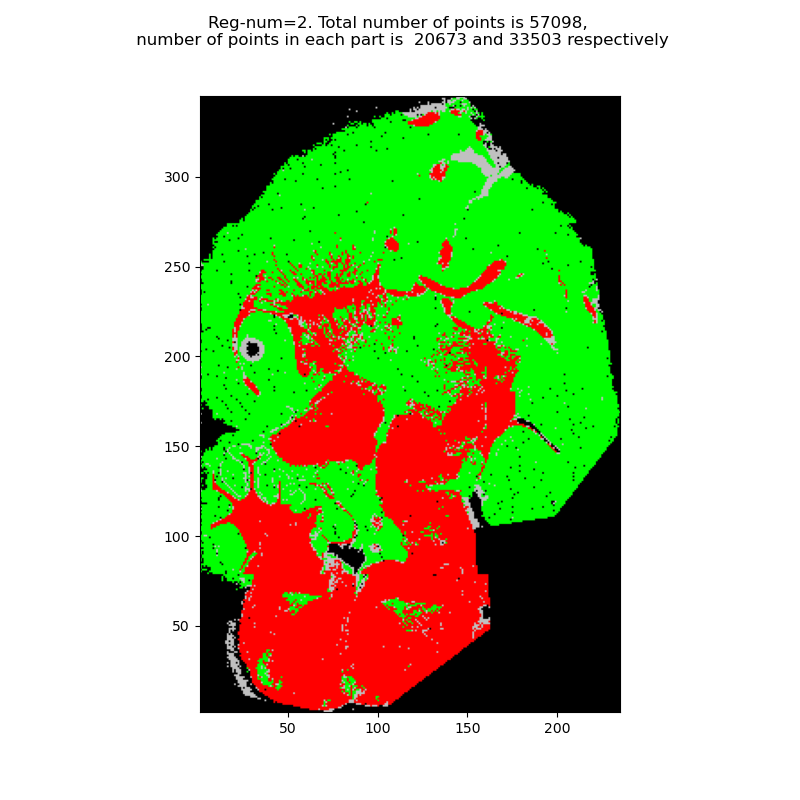

In [14]:
# Picture
set1=list_of_neisets[num1]
set2=list_of_neisets[num2]

cols=np.array([cl[-1] for i in range(number)])

for i in set1:
    cols[i]=cl[0]
for i in set2:
    cols[i]=cl[2]

Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
fig1.suptitle("Reg-num"+str(reg_num)+". Total number of points is "+str(len(v))+", \n number of points in each part is  "+str(len(list_of_neisets[num1]))+" and "+str(len(list_of_neisets[num2]))+" respectively")
plt.show() 

# Further approximation two clusters <a class="anchor" id="fourth-bullet"></a>

In [15]:
#Median value of extremal angle for each zone = optimal angle
phi1=cos(radians(np.median(extr_phi[set1])))
phi2=cos(radians(np.median(extr_phi[set2])))
print(phi1, phi2)

0.9885646206082471 0.9899470484380349


In [16]:
#Finding the optimal axis in each zone = the axis of the cone containing maximal number of points in it. 
#Cheching disjointness (not necessarily). If the sets are disjoint no long search is needed further.
num_of_pts_1=np.array([len(new_nei_set(i, cols_bin, phi1)) for i in set1])
num_of_pts_2=np.array([len(new_nei_set(i, cols_bin, phi2)) for i in set2])
best_num_1=np.argmax(num_of_pts_1)
best_num_2=np.argmax(num_of_pts_2)
new_zone1=new_nei_set(set1[best_num_1], cols_bin, phi1) 
new_zone2=new_nei_set(set2[best_num_2], cols_bin, phi2)
intersection_zone=set(new_zone1).intersection(new_zone2)
set(new_zone1).isdisjoint(new_zone2)

True

In [ ]:
#New (intersecting) cones.
cols2=np.array([cl[-1] for i in range(number)])
for i in new_zone1:
    cols2[i]=cl[0]
for i in new_zone2:
    cols2[i]=cl[2]
for i in intersection_zone:
    cols2[i]=cl[1]

Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols2[i]

fig = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
fig.suptitle("Reg-num"+str(reg_num)+". Number of points in each part is  "+str(len(new_zone1))+" and "+str(len(new_zone2))+" respectively.\n Number of points in intersection is "+str(len(intersection_zone)))
plt.show()   

In [ ]:
# PCA with intersection zone
pcv=PCA(n_components=5).fit_transform(v)
plt.figure(figsize=(10,6))
plt.scatter(pcv.T[0], pcv.T[1], s=2, c=cols2)
plt.show()

In [100]:
# If the previous gives non-disjoint sets. Execute the following. 
new_list_of_neisets1=[new_nei_set(i, cols_bin, phi1) for i in range(number)]
new_list_of_neisets2=[new_nei_set(i, cols_bin, phi2) for i in range(number)]
lenlist1=np.array([len(new_list_of_neisets1[i]) for i in range(number)])

arrofnei1=np.ones((number, number), dtype=int)
starttime=time.time()
for i in range(number):
    arrofnei1[i][new_list_of_neisets1[i]]=arrofnei1[i][new_list_of_neisets1[i]]-1
endtime=time.time()
print(endtime-starttime)

0.10272431373596191


In [ ]:
# Matrix of not neighbours of all the neighbours. If 1 then can be an axis of the other cone
starttime=time.time()
arrof_not_nei1=np.array([np.prod(arrofnei1[new_list_of_neisets2[i]], axis=0) for i in range(number)])
endtime=time.time()
print(endtime-starttime)

In [ ]:
#Search of 2 disjoint sets with different angles
arr_set1=np.zeros(number)
for i in set1:
    arr_set1[i]=arr_set1[i]+1

starttime=time.time()
maxv=0
for i in set2:
    set0=new_nei_set(i, cols_bin, phi2)
    try_list=np.flatnonzero((arrof_not_nei1[i]*arr_set1)>0)
    if (len(try_list)):
        try_list=np.array(try_list)
        k=np.argmax(lenlist1[try_list])
        if(len(set0)+lenlist1[try_list[k]]>maxv):
            best_num12=i
            best_num11=try_list[k]
            maxv=len(set0)+lenlist1[try_list[k]]
endtime=time.time()
print(endtime-starttime)

print(best_num11, best_num12)

final_set1=new_nei_set(best_num11, cols_bin, phi1)
final_set2=new_nei_set(best_num12, cols_bin, phi2)

In [ ]:
#Picture of new disjoint cones.
cols3=np.array([cl[-1] for i in range(number)])
for i in final_set1:
    cols3[i]=cl[0]
for i in final_set2:
    cols3[i]=cl[2]

Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols3[i]

fig = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
fig.suptitle("Number of points in each part is  "+str(len(final_set1))+" and "+str(len(final_set2))+" respectively.")
plt.show()  

# Three clusters. Preliminary segmentation <a class="anchor" id="fifth-bullet"></a>

In [ ]:
# Search of 3 disjoint sets
starttime=time.time()
maxv=0
for i in range(number):
    if(i%500==0):
        endtime=time.time()
        print(i, endtime-starttime)
        starttime=endtime
    temp_i=np.flatnonzero(arrof_not_nei[i][i+1:])+i+1
    for j in temp_i:
        try_list=np.flatnonzero((arrof_not_nei[i]*arrof_not_nei[j])[j+1:])+j+1
        if(len(try_list)):
            k=np.argmax(lenlist[try_list])
            if((lenlist[i]+lenlist[j]+lenlist[try_list[k]])>maxv):
                num11=i
                num12=j
                num13=try_list[k]
                maxv=lenlist[i]+lenlist[j]+lenlist[try_list[k]]
endtime=time.time()
print(endtime-starttime)

print(num11, num12, num13)

In [ ]:
# Picture

cols4=np.array([cl[-1] for i in range(number)])
for i in set11:
    cols4[i]=cl[1]
for i in set12:
    cols4[i]=cl[2]
for i in set13:
    cols4[i]=cl[0]

Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols4[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
fig1.suptitle("Reg-num is "+str(reg_num)+". Core points: 1766, 7950, 50104. \n Number of points in each part is  "+str(len(list_of_neisets[num11]))+", "+str(len(list_of_neisets[num12]))+", "+str(len(list_of_neisets[num13]))+" respectively")
plt.show() 

# Further approximation. Three clusters <a class="anchor" id="sixth-bullet"></a>

In [ ]:
#Median value of extremal angle for each zone = optimal angle
phi11=cos(radians(np.median(extr_phi[set11])))
phi12=cos(radians(np.median(extr_phi[set12])))
phi13=cos(radians(np.median(extr_phi[set13])))
print(coneangle, np.median(extr_phi[set11]), np.median(extr_phi[set12]), np.median(extr_phi[set13]))

In [25]:
# An array of neighbours for each vector in the sample
list_of_neisets11=[new_nei_set(i, cols_bin, phi11) for i in range(number)]
list_of_neisets12=[new_nei_set(i, cols_bin, phi12) for i in range(number)]
list_of_neisets13=[new_nei_set(i, cols_bin, phi13) for i in range(number)]
lenlist13=np.array([len(list_of_neisets13[i]) for i in range(number)])

#The neighbours with the angle phi12. 1 -- not neighbour, 0 -- the neighbour.
arrofnei12=np.ones((number, number), dtype=int)
for i in range(number):
    arrofnei12[i][list_of_neisets12[i]]=arrofnei12[i][list_of_neisets12[i]]-1

starttime=time.time()
# Matrix of not neighbours of all the neighbours. If 1 then can be an axis of the other cone. Inner angle is phi11, outer is phi12 
new_arrof_not_nei12=[np.prod(arrofnei12[list_of_neisets11[set11[i]]], axis=0) for i in range(len(set11))]
endtime=time.time()
print(endtime-starttime)

In [ ]:
arrofnei13=np.ones((number, number), dtype=int)
for i in range(number):
    arrofnei13[i][list_of_neisets13[i]]=arrofnei13[i][list_of_neisets13[i]]-1

starttime=time.time()    
new_arrof_not_nei13=[np.prod(arrofnei13[list_of_neisets11[set11[i]]], axis=0) for i in range(len(set11))]
endtime=time.time()
print(endtime-starttime)

starttime=time.time()
new_arrof_not_nei23=[np.prod(arrofnei13[list_of_neisets12[set12[i]]], axis=0) for i in range(len(set12))]
endtime=time.time()
print(endtime-starttime)

In [ ]:
#1 - belongs to set2, 0 -- doesn't
arr_set2=np.zeros(number)
for i in set12:
    arr_set2[i]=arr_set2[i]+1

#1 - belongs to set3, 0 -- doesn't
arr_set3=np.zeros(number)
for i in set13:
    arr_set3[i]=arr_set3[i]+1

In [ ]:
#Searching for three disjoint sets
maxsum=0
for i in range(len(set11)):
    set0=list_of_neisets11[set11[i]]
    try_list2=np.flatnonzero((new_arrof_not_nei12[i])[set12]>0)
    if(len(try_list2)):
        for j in try_list2:
            try_list3=np.flatnonzero((new_arrof_not_nei13[i]*arr_set3*new_arrof_not_nei23[j])>0)
            if (len(try_list3)):
                k=np.argmax(lenlist13[try_list3])
                if(len(set0)+len(list_of_neisets12[set12[j]])+lenlist13[try_list3[k]]>maxsum):
                    best_num21=set11[i]
                    best_num22=set12[j]
                    best_num23=try_list3[k]
                    maxsum=len(set0)+len(list_of_neisets12[set12[j]])+lenlist13[try_list3[k]]
                    
print(best_num21, best_num22, best_num23)

In [ ]:
#Final sets
final_set21=list_of_neisets11[best_num21]
final_set22=list_of_neisets12[best_num22]
final_set23=list_of_neisets13[best_num23]
print(set(final_set22).isdisjoint(final_set23), set(final_set21).isdisjoint(final_set23), set(final_set22).isdisjoint(final_set21))

In [ ]:
#Picture
cols5=np.array([cl[-1] for i in range(number)])
for i in final_set21:
    cols5[i]=cl[1]
for i in final_set22:
    cols5[i]=cl[0]
for i in final_set23:
    cols5[i]=cl[2]

Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols5[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
fig1.suptitle("Number of points in each part is  "+str(len(final_set21))+", "+str(len(final_set22))+", "+str(len(final_set23))+" respectively")
plt.show() 